### Objective
The objective of my analysis is to analyze and visualize NAIP imagery in an area of downtown Dover NH to see if the effects of a 2017 drought has long term effects on vegetation using NAIP imagery available in 2016 and 2018.
#### data
This analysis used NAIP imagery from 2016 and 2018. It also used New Hampshire landcover data available from NH Granit from 2015, cropped to the image study area.
#### methods 
I used rasterio and numpy to calculate NDVI based off the NAIP imagery for both 2016 and 2018. I then reclassified these images based on NDVI (>2.= healthy/vegetation and <.2=unhealthy/no vegetation). I then subtracted 2016 from 2018 to get the change in vegetation. I used this output to visualize where the greatest change in vegetation was occuring in the area of study. Then in part II of my analysis, I use pandas and geopandas to select and examine 4 land use categories to see if there were any significant differences in change between the two years.
#### results
Zonal Statistics for 4 selected land use categories show overall similar results to the analysis of the entire area of study - Forested land shows a better recovery compared to vegetation in other settings. It showed the fewest declines in vegetation health. Agricultural lands show a greater decrease in vegetation & vegetation health, but this may also be due to development or declining use of these lands for solely agricultural purposes. Residential areas show an overall increase, with areas of single family homes seeing more improvement in overall vegetation health. Multi-family and apartment building zoned areas may see a decline because they typically don't have large lawns to maintain, and it may be less of a priority for owners who rent vs live in their apartments. Overall, I believe this analysis showed results that met my expectations (measuring and overall decline or increase in vegetation health) but this type of analysis is better suited for examining a large area in aggregate. Examining areas by land cover classification was interesting, but too large-scale to show an overall trend. The most recently available land cover data is from 2015, rapid development in the area can change the results. It is difficult to quantify exactly where the increases and decreases are coming from, so visual inspection of the results led to more conclusions about the trend between the two years. Additionally, measuring NDVI between the 2 years may capture changes other than vegetation health differences (development), so analysis using just NDVI won't produce accurate results using this methodology.



In [1]:
import rasterio
from rasterio import plot 
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

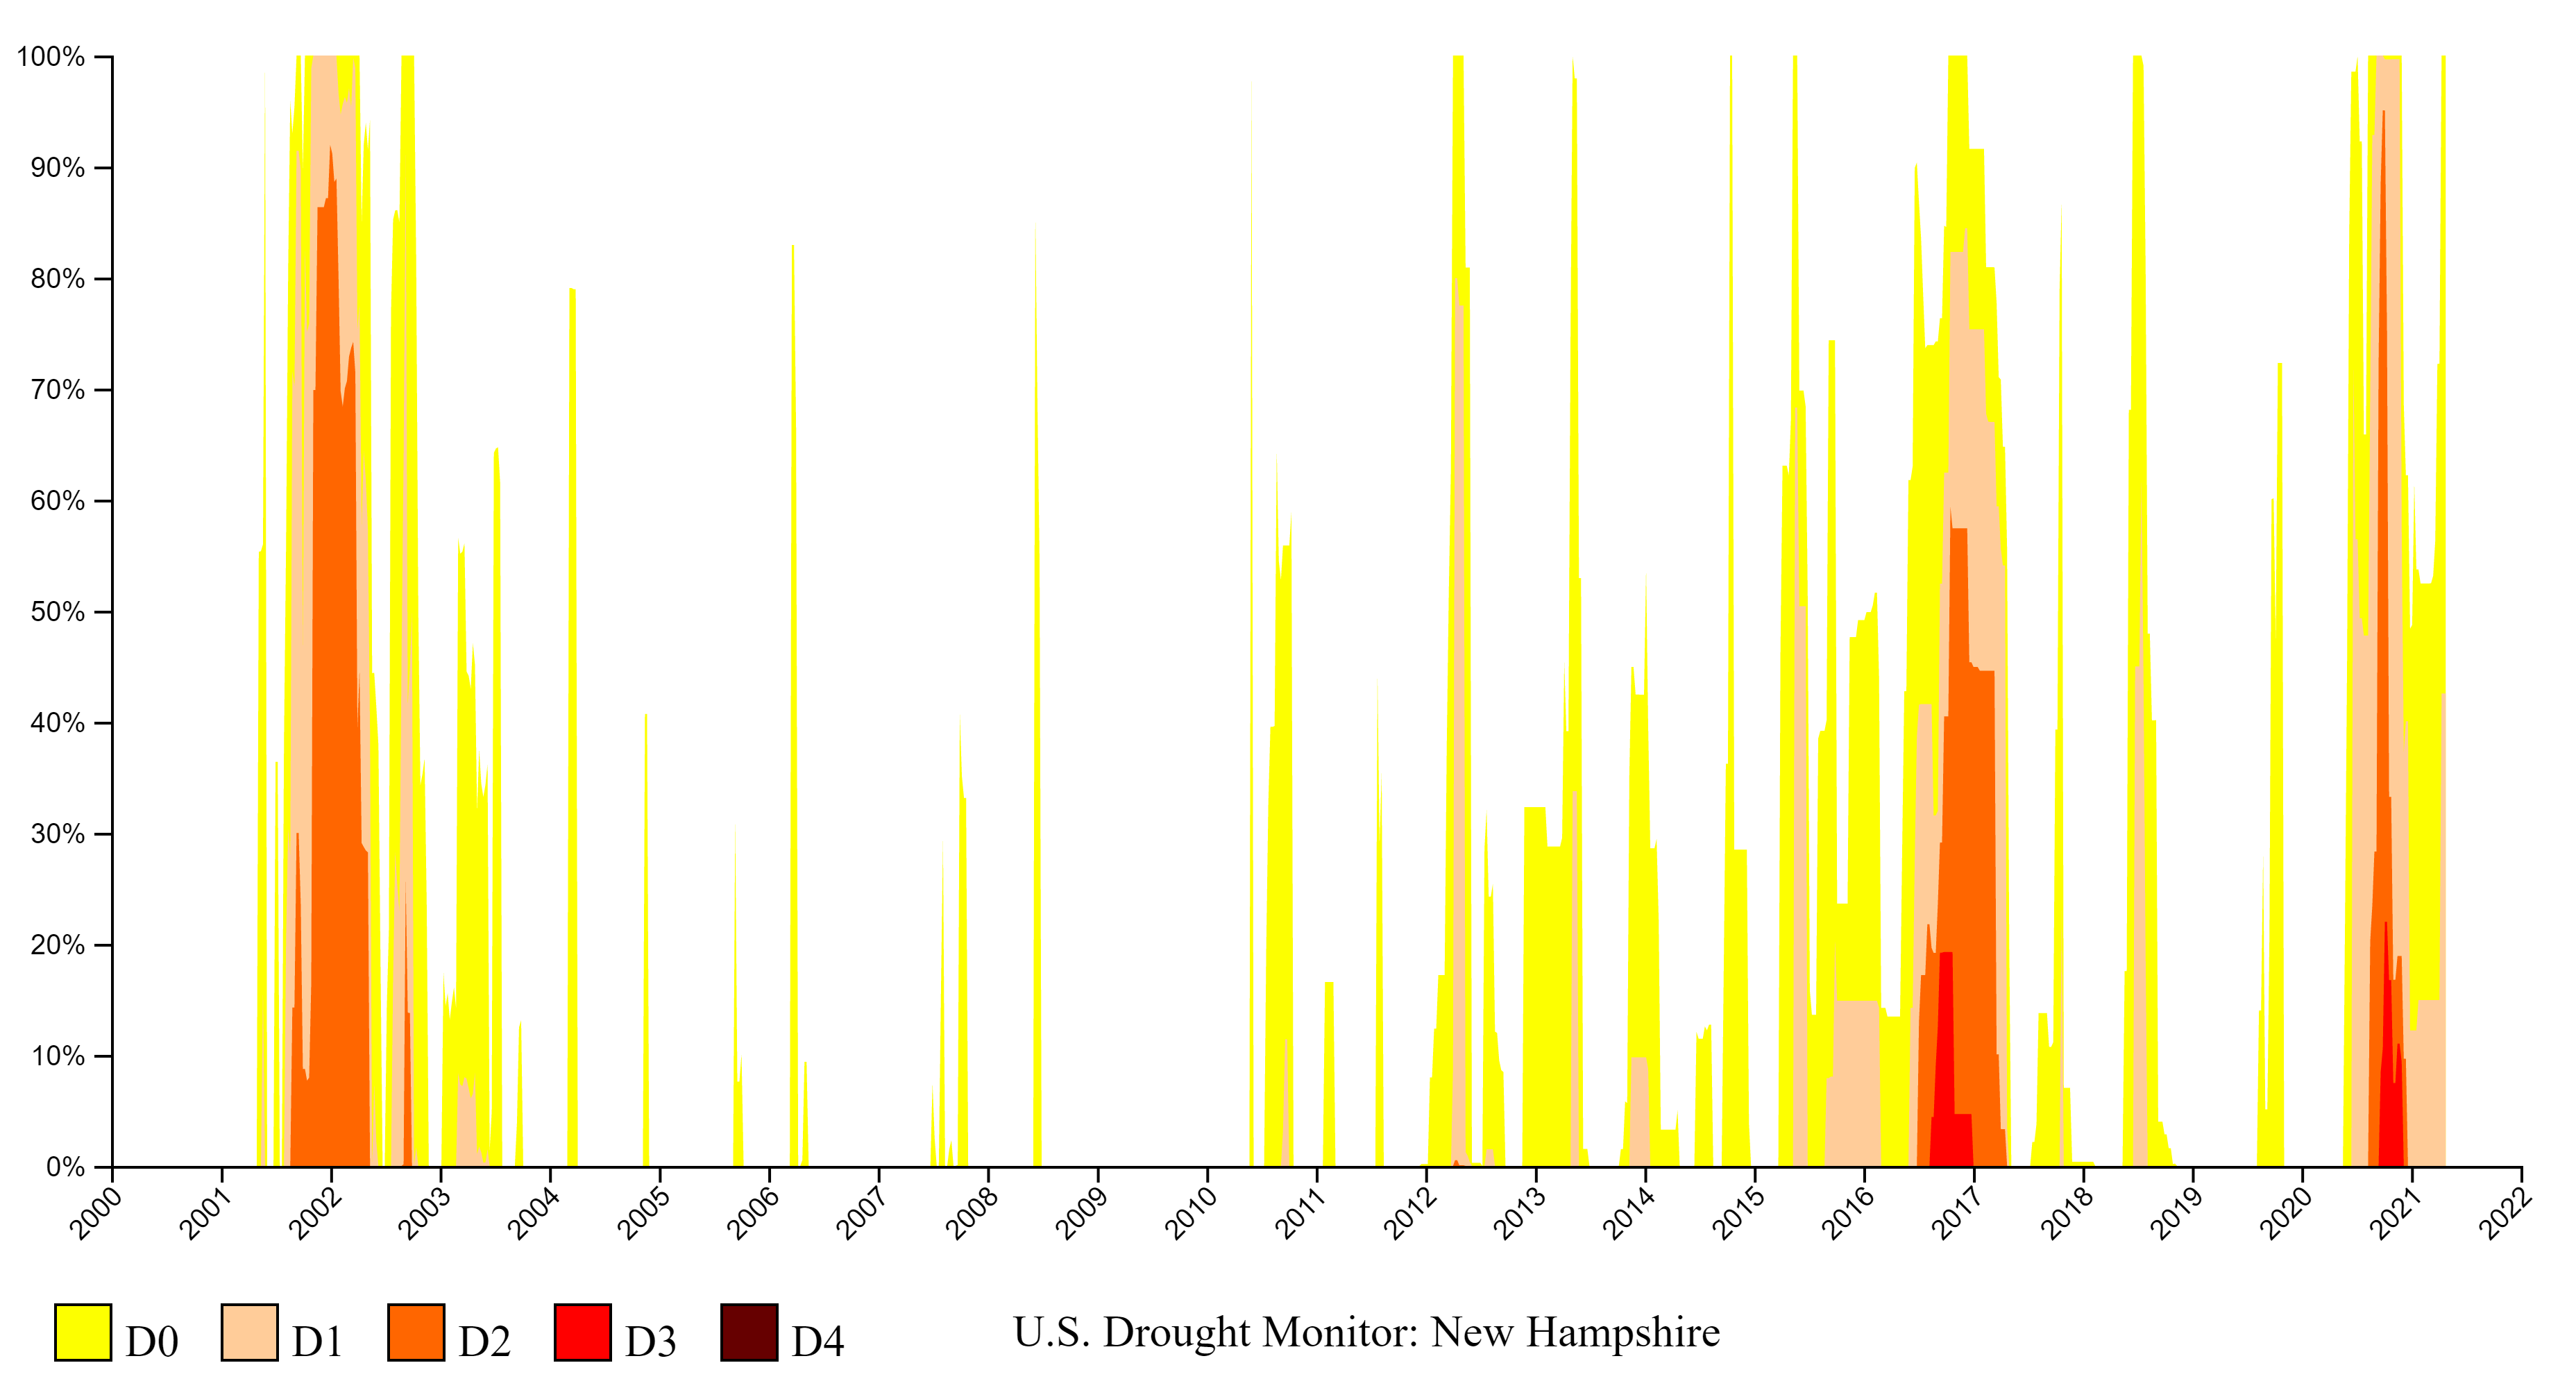

This graphic from the state of New Hampshire Drought Monitoring website shows that much of the state was in a moderate to severe drought during 2017.

In [2]:
# load the 2 images into rasterio
naip2016 = r'D:\NHLandcover\m_4307049_ne_19_h_20160706.tif'
naip2018 = r'D:\NHLandcover\m_4307049_ne_19_060_20181016_20190225.tif'

# Open the tif files using rasterio
src2016 = rasterio.open(naip2016)
src2018 = rasterio.open(naip2018)

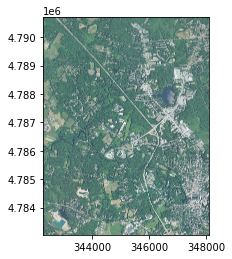

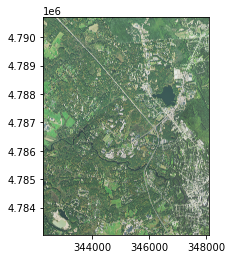

<AxesSubplot:>

In [3]:
# Plot the two years using rasterio plot.show()
plot.show(src2016)
plot.show(src2018)

In [4]:
def openNAIP(nfile):
    # Use rasterio to select imagery bands, and then calculate NDVI using numpy
    with rasterio.open(nfile) as src:
        red = src.read(1).astype('float64')
        nir = src.read(4).astype('float64')
        
        #calculate ndvi values
        ndvi = np.where((nir+red) == 0, 0, (nir-red)/(nir+red))
        return ndvi

def getCRS(nfile):
    #with rasterio.open(nfile) as src:
    #incrs = src.crs
    from osgeo import gdal
    incrs = gdal.Open(nfile).GetProjectionRef()
    return incrs

In [22]:
# Save the ndvi for each year
calc2018 = openNAIP(naip2018)
calc2016 = openNAIP(naip2016)

In [6]:
# Use numpy to reclassify the NDVI values into healthy vegetation vs non-healthy/non-vegetation
def reclassify(raster):
    # Reclassfy values
    # 0: No Vegetation, 1: Vegetation
    global img
    img = raster
    img[img>.2] = 1
    img[img<=.2] = 0
    return img

In [7]:
# Store the results
reclass2018 = reclassify(calc2018)
reclass2016 = reclassify(calc2016)

In [8]:
# change the values of 2019 to identify where change has occured 
#(2=No change, 1=increase, 4=decrease, 3=No change )
change = ((reclass2018 + 1) * 2) - reclass2016

In [9]:
# Quick view - What percent of the values in the image changed?
print(round(np.count_nonzero(change == 1)/np.count_nonzero(change),3)*100, "Percent increased")
print(round((np.count_nonzero(change == 2)+np.count_nonzero(change == 3))/np.count_nonzero(change),3)*100, "Percent no change")
print(round(np.count_nonzero(change == 4)/np.count_nonzero(change),3)*100, "Percent decreased")

23.200000000000003 Percent increased
70.19999999999999 Percent no change
6.6000000000000005 Percent decreased


In [10]:
from rasterio.crs import CRS
def writeFile(outfile,indata,incrs):
    affine= incrs.transform
    with rasterio.open(outfile, 'w', 
                                   driver='GTiff',
                                   height=indata.shape[0],
                                   width=indata.shape[1],
                                   compress='lzw', #lossless
                                   count=1,
                                   dtype= 'float64', # 'uint8' for reclass
                                   crs= incrs.crs,transform=affine) as dst:
        dst.write(indata,1)

In [11]:
# Define the array's projection to save as a georeferenced tiff later
with rasterio.open(naip2016) as src:
    crs = src.crs

In [12]:
# write the reclassified NDVI files
basepath = r'D:\NHLandcover'
changepath = os.path.join(basepath,'change.tif')
#writeFile(changepath,change,src)

In [17]:
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterio.plot import show_hist

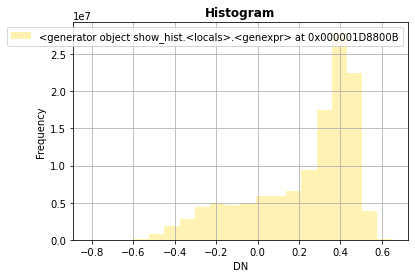

In [23]:
# View a histogram of the raw NDVI values pre-drought
show_hist(calc2016, bins=20, lw=0.0, stacked=False, alpha=0.3,
        histtype='stepfilled', title="Histogram")

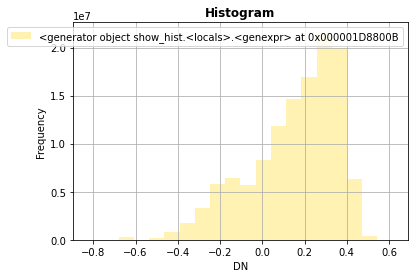

In [24]:
# View a histogram of the raw NDVI values post-drought
show_hist(calc2018, bins=20, lw=0.0, stacked=False, alpha=0.3,
        histtype='stepfilled', title="Histogram")

### 2016 shows higher concentration of healthy ndvi values (factors could include time of photograhy, vegetation type) with NDVI values concentrated in .35-.45 range in 2016 - higher % of healthy vegetation?
### 2018 shows lower NDVI values overall, with less concentration near .4 - overall, vegetation could still be affected

In [25]:
def REreclassify(raster):
    # Reclassfy values
    # 0: No Vegetation, 1: Vegetation
    global img
    img = raster
    img[img==2] = 0
    img[img==3] = 0
    img[img<2] = 2
    img[img>3] = 1
    return img

In [26]:
# reclassify again to show the overall change in vegetation
change_reclass = REreclassify(change)

Text(0.5, 1.0, 'NDVI change')

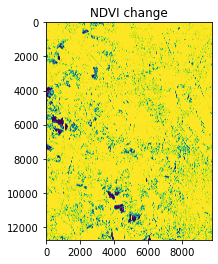

In [27]:
# Show overall change in the area of study
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10, 4), sharey=True)
show(change_reclass, ax=ax1)

ax1.set_title("NDVI change")

## Visual examination of results
### Red shows vegetation/NDVI decrease, green shows increase
### Most affected areas were open space (fields, baseball, parks) and residential lawns
### Increase in NDVI - mostly trees - certain types of vegetation are more resilient to drought (trees), people following water restrictions and not mowing their lawn?

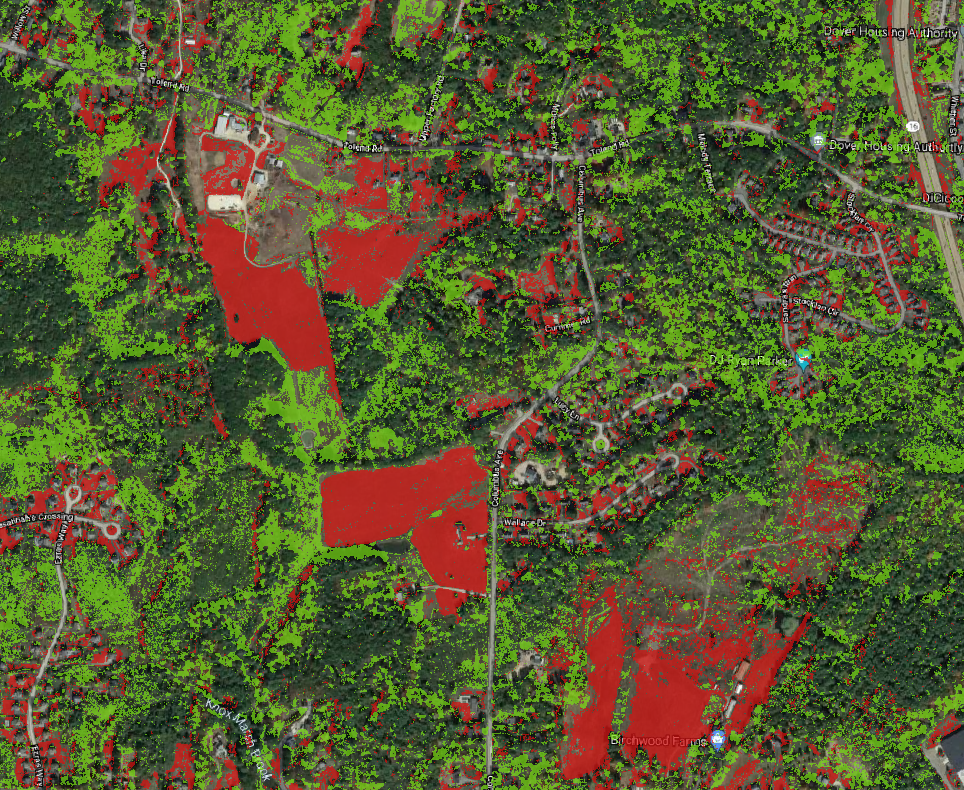

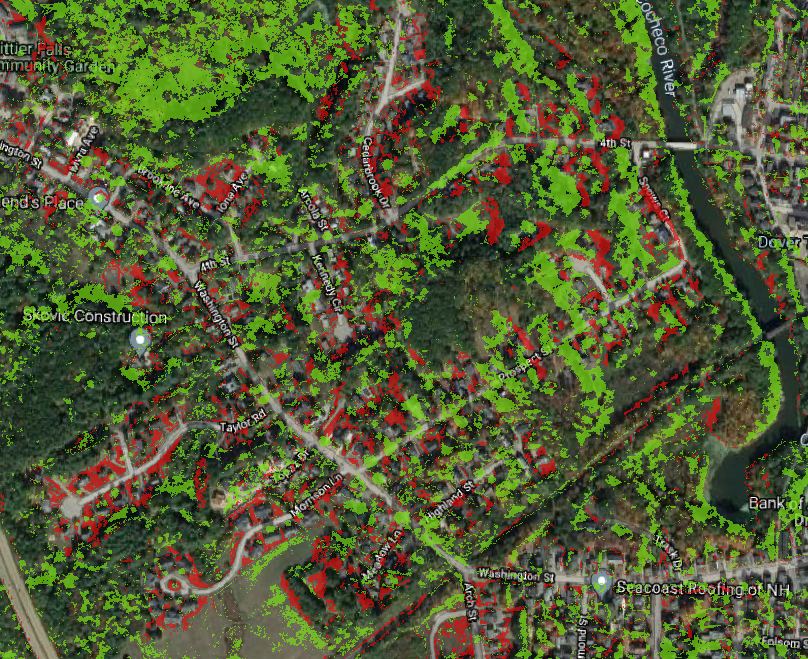

### Part II - Pandas analysis

In [35]:
import geopandas as gpd
import pandas as pd
from shapely import speedups
speedups.disable()

In [36]:
LUC=gpd.read_file(r'D:\NHLandcover\seNH_Landcover_2015.gpkg')

In [37]:
LUC.LU4_Desc.unique()

array(['Office park', 'Other mixed uses', 'Institutional', 'Educational',
       'Disturbed Land',
       'Multiple stories, residential in upper stories only', 'Mining',
       'Industrial', 'Auxiliary transportation', 'Single family/duplex',
       'Agricultural Land', 'Parking structure/lot',
       'Rail transportation', 'Wetlands', 'Road right-of-way',
       'Park & ride lot', 'Commercial wholesale', 'Lodging',
       'Vacant Land', 'Electric, gas and other utilities',
       'Communication', 'Forest Land', 'Water', 'Government',
       'Water and wastewater utilities',
       'Indoor cultural/public assembly',
       'Multi-family, low rise apartments and townhouses, but not duplexes (1 - 3 stories)',
       'Services', 'Limited & controlled highway right-of-way',
       'Other Agricultural Land',
       'Other transportation, communications, and utilities',
       'Outdoor recreation', 'Mobile home parks',
       'Brush or Transitional Between Open and Forested',
       'Mainta

In [38]:
lc_list = ['Agricultural Land','Forest Land','Multi-family, low rise apartments and townhouses, but not duplexes (1 - 3 stories)','Single family/duplex']
luc = LUC.loc[LUC['LU4_Desc'].isin(lc_list)]

In [39]:
luc.crs

<Projected CRS: EPSG:26919>
Name: NAD83 / UTM zone 19N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 72°W and 66°W - onshore and offshore. Canada - Labrador; New Brunswick; Nova Scotia; Nunavut; Quebec. Puerto Rico. United States (USA) - Connecticut; Maine; Massachusetts; New Hampshire; New York (Long Island); Rhode Island; Vermont.
- bounds: (-72.0, 14.92, -66.0, 84.0)
Coordinate Operation:
- name: UTM zone 19N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [40]:
luc["area"] = luc['geometry'].area
luc.area.sum()

C:\Users\kaitl\anaconda3\envs\py38\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


24253405.196392253

In [41]:
from rasterstats import zonal_stats

In [42]:
changeraster = rasterio.open(r'D:\NHLandcover\change.tif')

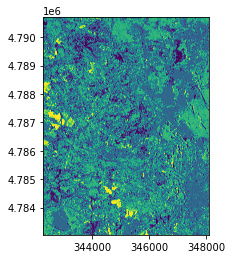

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

In [43]:
ax = show((changeraster, 1))
luc.plot(ax=ax, facecolor='None', edgecolor='red', linewidth=2)

In [44]:
array = changeraster.read(1)
affine = changeraster.transform

In [45]:
lucdis = luc.dissolve(by='LU4_Desc')

In [46]:
lucdis= lucdis.reset_index()

In [47]:
lucdis = gpd.GeoDataFrame(lucdis.dropna(axis=1, thresh=1))

In [48]:
lucdis.head()

LU4_Desc  \
0                                  Agricultural Land   
1                                        Forest Land   
2  Multi-family, low rise apartments and townhous...   
3                               Single family/duplex   

                                            geometry   LU4  Developed   Town  \
0  MULTIPOLYGON (((344987.582 4783403.546, 344748...  2000          0  Dover   
1  MULTIPOLYGON (((347042.413 4783568.314, 346962...  4000          0  Dover   
2  MULTIPOLYGON (((347636.139 4783367.330, 347635...  1120          1  Dover   
3  MULTIPOLYGON (((347634.175 4783343.261, 347569...  1130          1  Dover   

    FIPS RPA   Acres  rval      _count          area  
0  17010   9  40.498    11   6956746.0  1.327742e+06  
1  17010   9   4.670    22  69147468.0  1.319711e+07  
2  17010   9   0.587    27   5122370.0  9.776084e+05  
3  17010   9   6.120    10  45851598.0  8.750948e+06

In [49]:
# Seperate each land use category
luc_forest = lucdis.loc[lucdis['LU4_Desc'] == 'Forest Land']
luc_ag = lucdis.loc[lucdis['LU4_Desc'] == 'Agricultural Land']
luc_multi = lucdis.loc[lucdis['LU4_Desc'] == 'Multi-family, low rise apartments and townhouses, but not duplexes (1 - 3 stories)']
luc_single = lucdis.loc[lucdis['LU4_Desc'] == 'Single family/duplex']

In [50]:
# Use zonal stats to calculate the count of pixels in each selected land use category
stats_forest = zonal_stats(luc_forest, array, affine=affine, stats=['count'],categorical=True)
stats_ag = zonal_stats(luc_ag, array, affine=affine, stats=['count'],categorical=True)
stats_multi = zonal_stats(luc_multi, array, affine=affine, stats=['count'],categorical=True)
stats_single = zonal_stats(luc_single, array, affine=affine, stats=['count'],categorical=True)

C:\Users\kaitl\anaconda3\envs\py38\lib\site-packages\rasterstats\io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [51]:
# Create dataframe to summarize the data
stats = pd.DataFrame(stats_forest)
stats= stats.append(stats_ag)
stats=stats.append(stats_multi)
stats=stats.append(stats_single)
stats['LUC'] = ''
stats.iloc[0,5] = 'Forest Land'
stats.iloc[1,5]= 'Agricultural Land'
stats.iloc[2,5]= 'Multi-family, low rise apartments and townhouses, but not duplexes (1 - 3 stories)'
stats.iloc[3,5]= 'Single family/duplex'

In [52]:
stats = stats.rename(columns={2.0:'No_change', 1.0:'increase', 4.0:'decrease', 3.0:'No_change2'})

In [53]:
stats['increase_pct'] = stats['increase']/stats['count']
stats['decrease_pct'] = stats['decrease']/stats['count']

In [54]:
stats

increase  No_change  No_change2  decrease     count  \
0  10411937    1783291    23591386    871754  36658368   
0    870275     706837      998009   1113049   3688170   
0    392565    1542572      583861    196623   2715621   
0   4941659    7989367     8848352   2528954  24308332   

                                                 LUC  increase_pct  \
0                                        Forest Land      0.284026   
0                                  Agricultural Land      0.235964   
0  Multi-family, low rise apartments and townhous...      0.144558   
0                               Single family/duplex      0.203291   

   decrease_pct  
0      0.023780  
0      0.301789  
0      0.072404  
0      0.104037